# Herd Immunity Modeling

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from IPython.display import clear_output

## Rules:

1. Number of agents is **GRID_WIDTH * GRID_HEIGHT = NUM_AGENTS**. Each point in the rectangular grid is occupied by an agent.

2. Agents are randomly assigned an **IMMUNE** status, either 0 (susceptible) or 1 (immune), at the beginning. **NUM_IMMUNE_START = PERC_IMMUNE_START * NUM_AGENTS**

3. Agents are initially randomly flagged as sick, with **NUM_SICK_START = PERC_SICK_START * NUM_AGENTS.** Immune agents cannot be initially flagged as sick.

4. At each period, agents connect with some of the agents around them, with probability of connecting to agents within their **CONNECTION_DISTANCE** being determined by a function. This determines the candidate pool a given agent could connect with:

   1. If **CONNECTION_DISTANCE = 1**, agents have a candidate pool of  <= 8, that is, the agents directly around them in a square with themself at the center

   2. If **CONNECTION_DISTANCE = 2,** agents have a candidate pool of <= 16, that is, the agents directly around them in 2 concentric squares with themself at the center

   3. etc. with **CONNECTION_DISTANCE <= MAX(GRID_WIDTH, GRID_HEIGHT) - 1**

5. If a sick agent connects with a healthy agent who is not immune, probability of infection is **PROB_INFECTION.** If a sick agent connects with an immune agent, probability of infection is zero (could change later accounting for imperfect vaccination success rate).

6. After **PERIODS_SURVIVED** periods, sick agents die and no longer pose a threat to healthy agents.

7. If after **PERIODS_FOR_STABILITY**, number of sick agents has not increased, the population is said to be stable and simulation ends.

In [2]:
def num_to_idxs(num):
    '''Takes agent number (from 0 to NUM_AGENTS-1) and returns 2d index (down, across)'''
    return num//GRID_WIDTH, num%GRID_WIDTH

In [3]:
def idxs_to_num(down, across):
    '''Takes indices in down, across form and returns 1d agent number'''
    return down * GRID_WIDTH + across

In [4]:
def get_probabilities(choices : np.ndarray, exclude : np.ndarray) -> np.ndarray:
    probs = np.ones(len(choices))
    if exclude is not None:
        probs[exclude.astype(bool)] = 0
    probs[probs == 1] = 1 / sum(probs)
    assert np.isclose(sum(probs), 1.0)
    return probs

In [5]:
def initialize_array(num_agents : int, num_ones : int, exclude : np.ndarray) -> np.ndarray:
    # Set up initial 1d array
    agents = np.zeros(num_agents)
    
    # Randomly select locations for ones, incorporating exclusions
    probs = get_probabilities(agents, exclude=exclude)
    selections = np.random.choice(range(num_agents), size=num_ones, replace=False, p=probs)
    agents[selections] = 1
    
    assert np.sum(agents) == num_ones
    return agents

In [6]:
def reset():
    # Setup immunity
    immune_arr = initialize_array(
        num_agents=NUM_AGENTS,
        num_ones=NUM_IMMUNE_START,
        exclude=None
    )
    
    # Setup sickness
    sick_arr = initialize_array(
        num_agents=NUM_AGENTS,
        num_ones=NUM_SICK_START,
        exclude=immune_arr
    )
    
    # Setup health
    healthy_arr = np.ones(NUM_AGENTS)
    healthy_arr = healthy_arr - sick_arr
    
    # Setup death
    dead_arr = np.zeros(NUM_AGENTS)

    return immune_arr, healthy_arr, sick_arr, dead_arr

In [7]:
def get_neighbors(num_agent : int) -> np.ndarray:
    '''Takes in agent number and returns of tuple of adjacent agent numbers according to CONNECTION_DISTANCE'''
    down, across = num_to_idxs(num_agent)
    
    # Determine bounds according to CONNECTION_DISTANCE
    low_horiz_bound = across - CONNECTION_DISTANCE
    high_horiz_bound = across + CONNECTION_DISTANCE
    low_vert_bound = down - CONNECTION_DISTANCE
    high_vert_bound = down + CONNECTION_DISTANCE

    # Vectorized for speed
    neighbors = ALL_IDXS[
        (low_vert_bound <= ALL_IDXS[:,0])
        & (ALL_IDXS[:,0] <= high_vert_bound)
        & (low_horiz_bound <= ALL_IDXS[:,1])
        & (ALL_IDXS[:,1] <= high_horiz_bound)
    ]
    
    # Transform neighboring indices back to agent numbers
    neighbor_nums = idxs_to_num(neighbors[:,0], neighbors[:,1])
    neighbor_nums = neighbor_nums[neighbor_nums != num_agent] # exclude input
    
    return neighbor_nums

In [8]:
def get_interaction_matrix():
    # Bidirectional because either agent can initialize an interaction and once interacting they affect one another
    
    # Setup interaction matrix
    interaction_matrix = np.zeros((NUM_AGENTS, NUM_AGENTS))
    
    # Every agent feels a random level of sociability each function call
    sociability_arr = get_sociability_arr()
    
    # Build graph
    for sociability, agent in zip(sociability_arr, range(NUM_AGENTS)):
        neighbors = get_neighbors(agent)
        interaction_idxs = np.random.binomial(1, sociability, size=len(neighbors))
        neighbors_interacted_with = neighbors[interaction_idxs.astype(bool)]
        
#         print(sociability, neighbors, interaction_idxs, neighbors_interacted_with)
#         return
        
#         if agent == 0: print(sociability, agent, neighbors, neighbors_interacted_with)
  
        interaction_matrix[agent, neighbors_interacted_with] = 1
        
    return interaction_matrix

In [9]:
def set_sick(agents):
    sick_arr[agents] = 1
    healthy_arr[agents] = 0

In [10]:
def set_healthy(agents):
    healthy_arr[agents] = 1
    sick_arr[agents] = 0

In [11]:
def set_dead(agents):
    dead_arr[agents] = 1
    sick_arr[agents] = 0

In [12]:
def set_immune(agents):
    immune_arr[agents] = 1
    healthy_arr[agents] = 0

In [13]:
def get_sick_agents():
    return np.where(sick_arr == 1)[0]

In [14]:
def get_exposed_agents(sick_agent, interaction_matrix):
    return np.where(interaction_matrix[sick_agent,:] == 1)[0]

In [15]:
def do_timestep():
    
    ## Everyone feels better or dies "overnight" (if timesteps are days)
    
    # See if anyone gets better
    sick_agents = np.where(sick_arr == 1)[0]
    got_better = np.random.binomial(1, PROB_RECOVERY, size=len(sick_agents)).astype(bool)
    set_healthy(sick_agents[got_better])
    if IMMUNE_AFTER_RECOVERY:
        set_immune(sick_agents[got_better])
    
    # See if anyone dies
    sick_agents = np.where(sick_arr == 1)[0]
    died = np.random.binomial(1, PROB_DEATH, size=len(sick_agents)).astype(bool)
    set_dead(sick_agents[died])
    
    ## Everyone interacts and possibly gets sick during the day
    
    # Obtain matrix of interactions for timestep
    interaction_matrix = get_interaction_matrix()
    
    plot_interactions(interaction_matrix)
    
    # See who gets infected by sick agents
    sick_agents = get_sick_agents()
    became_sick = []
    for sick_agent in sick_agents:
        # Healthy, alive, and non-immune agents that interacted with sick agents are at_risk if they're not immune or dead
        exposed_agents = get_exposed_agents(sick_agent, interaction_matrix)
        healthy = healthy_arr[exposed_agents].astype(bool)
        immune = immune_arr[exposed_agents].astype(bool)
        dead = dead_arr[exposed_agents].astype(bool)
        at_risk_agents = exposed_agents[(healthy) & (~immune) & (~dead)]

        # at_risk agents become sick with PROB_INFECTION
        got_sick = np.random.binomial(1, PROB_INFECTION, size=len(at_risk_agents)).astype(bool)
        became_sick += list(at_risk_agents[got_sick])
    
    set_sick(became_sick)

In [16]:
def plot_interactions(interaction_matrix):
    if clear: clear_output(wait=True)
    from matplotlib import colors

    # immune = 1, blue
    # healthy = 2, green
    # sick = 3, red
    # dead = 4, black
    
    plot_matrix = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    dead_matrix = dead_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[dead_matrix == 1] = 4
    sick_matrix = sick_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[sick_matrix == 1] = 3
    healthy_matrix = healthy_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[healthy_matrix == 1] = 2
    immune_matrix = immune_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[immune_matrix == 1] = 1
    
    bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    cmap = colors.ListedColormap(['white', COLOR_IMMUNE, COLOR_HEALTHY, COLOR_SICK, COLOR_DEAD])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(GRID_WIDTH//2+1, GRID_HEIGHT//2+1))

    ax.imshow(plot_matrix, cmap=cmap, norm=norm)

    sick_agents = get_sick_agents()
    
    for sick_agent in sick_agents:
        exposed_agents = get_exposed_agents(sick_agent, interaction_matrix)
        healthy = healthy_arr[exposed_agents].astype(bool)
        immune = immune_arr[exposed_agents].astype(bool)
        dead = dead_arr[exposed_agents].astype(bool)
        at_risk_agents = exposed_agents[(healthy) & (~immune) & (~dead)]
        
        sick_down, sick_across = num_to_idxs(sick_agent)
        for at_risk_agent in at_risk_agents:
            at_risk_down, at_risk_across = num_to_idxs(at_risk_agent)
            ax.plot([at_risk_across, sick_across], [at_risk_down, sick_down], color='pink', lw=3, marker='o', markerfacecolor='black', markeredgecolor='black')
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim(left=-0.5, right=GRID_WIDTH-0.5)
    ax.set_ylim(top=-0.5, bottom=GRID_WIDTH-0.5)
    ax.set_xticks(np.arange(-0.5, GRID_WIDTH, 1));
    ax.set_yticks(np.arange(-0.5, GRID_HEIGHT, 1));
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

In [17]:
def plot_grid():
    if clear: clear_output(wait=True)
    from matplotlib import colors

    # immune = 1, blue
    # healthy = 2, green
    # sick = 3, red
    # dead = 4, black
    
    plot_matrix = np.zeros((GRID_HEIGHT, GRID_WIDTH))
    dead_matrix = dead_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[dead_matrix == 1] = 4
    sick_matrix = sick_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[sick_matrix == 1] = 3
    healthy_matrix = healthy_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[healthy_matrix == 1] = 2
    immune_matrix = immune_arr.reshape(GRID_HEIGHT, GRID_WIDTH)
    plot_matrix[immune_matrix == 1] = 1
    
    bounds = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    cmap = colors.ListedColormap(['white', COLOR_IMMUNE, COLOR_HEALTHY, COLOR_SICK, COLOR_DEAD])
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(GRID_WIDTH//2+1, GRID_HEIGHT//2+1))

    ax.imshow(plot_matrix, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xlim(left=-0.5, right=GRID_WIDTH-0.5)
    ax.set_ylim(top=-0.5, bottom=GRID_WIDTH-0.5)
    ax.set_xticks(np.arange(-0.5, GRID_WIDTH, 1));
    ax.set_yticks(np.arange(-0.5, GRID_HEIGHT, 1));
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

In [27]:
def get_sociability_arr():
#     return np.random.random(NUM_AGENTS)
#     return np.ones(NUM_AGENTS)
    return np.ones(NUM_AGENTS) * 0.1

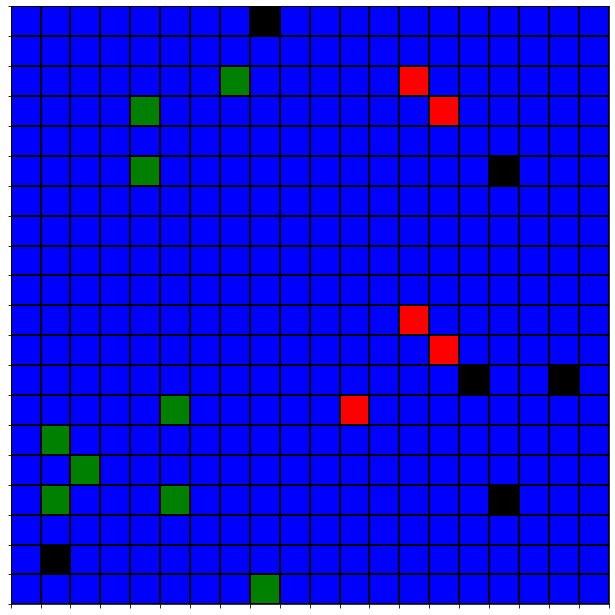

In [30]:
# Colors
COLOR_IMMUNE = 'blue'
COLOR_HEALTHY = 'green'
COLOR_SICK = 'red'
COLOR_DEAD = 'black'

# Inputs
GRID_WIDTH = 20
GRID_HEIGHT = 20
PROB_INFECTION = 1
PERC_IMMUNE_START = 0.95 # HERD IMMUNITY THRESH
PERC_SICK_START = 0.01
CONNECTION_DISTANCE = 5
PROB_DEATH = 0.1
PROB_RECOVERY = 0.1
IMMUNE_AFTER_RECOVERY = False

# Derived constants
NUM_AGENTS = GRID_WIDTH * GRID_HEIGHT
assert PERC_IMMUNE_START + PERC_SICK_START <=1, 'Impossible!'
MAX_REASONABLE_CONNECTION_DISTANCE = max(GRID_WIDTH, GRID_HEIGHT) - 1
if CONNECTION_DISTANCE > MAX_REASONABLE_CONNECTION_DISTANCE: CONNECTION_DISTANCE = MAX_REASONABLE_CONNECTION_DISTANCE
NUM_IMMUNE_START = int(np.round(PERC_IMMUNE_START * NUM_AGENTS, 0))
NUM_SICK_START = int(np.round(PERC_SICK_START * NUM_AGENTS, 0))
ALL_IDXS = np.array(list(itertools.product(range(GRID_HEIGHT), range(GRID_WIDTH))))

immune_arr, healthy_arr, sick_arr, dead_arr = reset()

wait = 0.5
clear = True
plot_grid()
time.sleep(wait)
now = time.time()
while time.time() - now <= 30:
    do_timestep()
    time.sleep(wait)
    plot_grid()
    time.sleep(wait)